https://www.datascience.com/blog/python-anomaly-detection

some introductory knowledge of anomaly detection, including how to use low-pass filter and simple moving average to detect abnormalities

In [50]:
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [51]:
# 1. Download sunspot dataset and upload the same to dataset directory
#    Load the sunspot dataset as an Array
# !mkdir -p dataset
# !wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()

,Months,SunSpots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


In [52]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in zip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.Series.rolling(residual, window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.iloc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1, title_for_plot=None,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)
    plt.title(title_for_plot)
    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

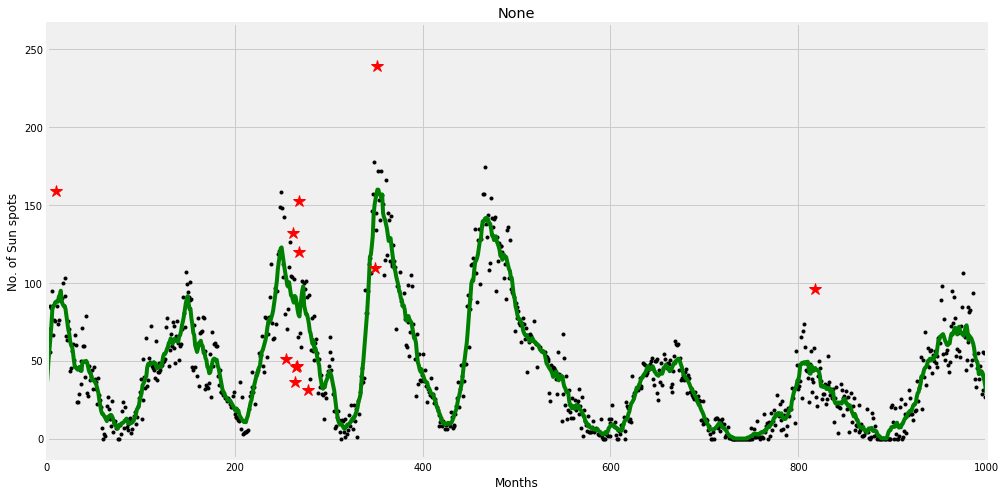

Information about the anomalies model:      anomalies_dict  standard_deviation
10             158.6              11.424
253            142.5              11.424
255             51.0              11.424
262            132.2              11.424
264             36.0              11.424
268            152.7              11.424
278             31.1              11.424
349            109.3              11.424
352            238.9              11.424
361            165.7              11.424
818             96.2              11.424
986             93.4              11.424
1055           206.3              11.424
1069            84.8              11.424
1172           107.1              11.424
1182            52.2              11.424
1185           180.4              11.424
1464            88.3              11.424
1735           129.2              11.424
1882           107.2              11.424
1890           103.6              11.424
1897           108.2              11.424
2023           154.

In [53]:
# 4. Lets play with the functions
x = data_as_frame['Months']
Y = data_as_frame['SunSpots']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Months", sigma_value=3,
             text_ylabel="No. of Sun spots")
events = explain_anomalies(Y, window_size=5, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(pd.DataFrame(events)))

In [54]:
# Convenience function to add noise
def noise(yval):
    """ Helper function to generate random points """
    np.random.seed(0)
    return 0.2*np.asarray(yval)*np.random.normal(size=len(yval))

# Generate a random dataset
def generate_random_dataset(size_of_array=1000, random_state=0):
    """ Helps in generating a random dataset which has a normal distribution
    Args:
    -----
        size_of_array (int): number of data points
        random_state (int): to initialize a random state

    Returns:
    --------
        a list of data points for dependent variable, pandas.Series of independent variable
    """
    np.random.seed(random_state)
    y = np.random.normal(0, 0.5, size_of_array)
    x = np.array(range(0, size_of_array))
    y_new = [y_i + index**((size_of_array - index)/size_of_array) 
              for index, y_i in zip(count(), y)]
    y_new *=  1 + noise(y)
    return x, pd.Series(y_new)

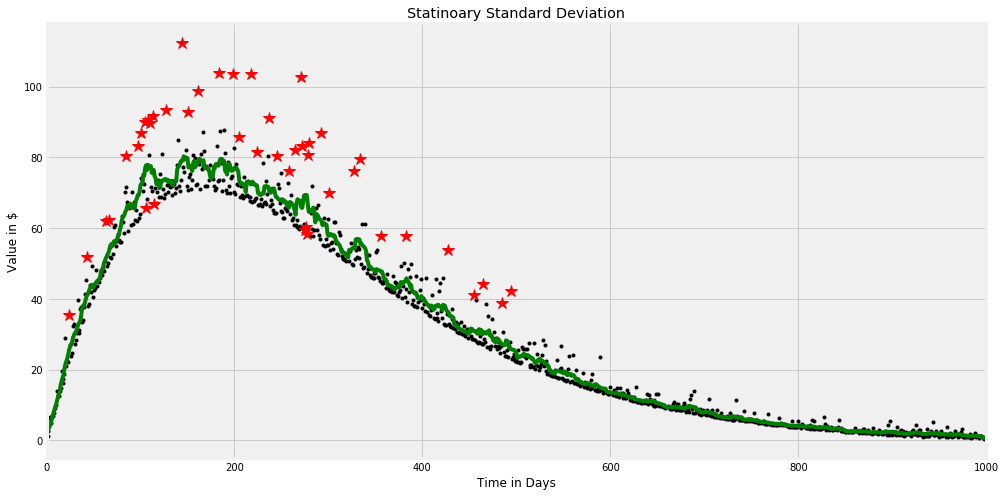

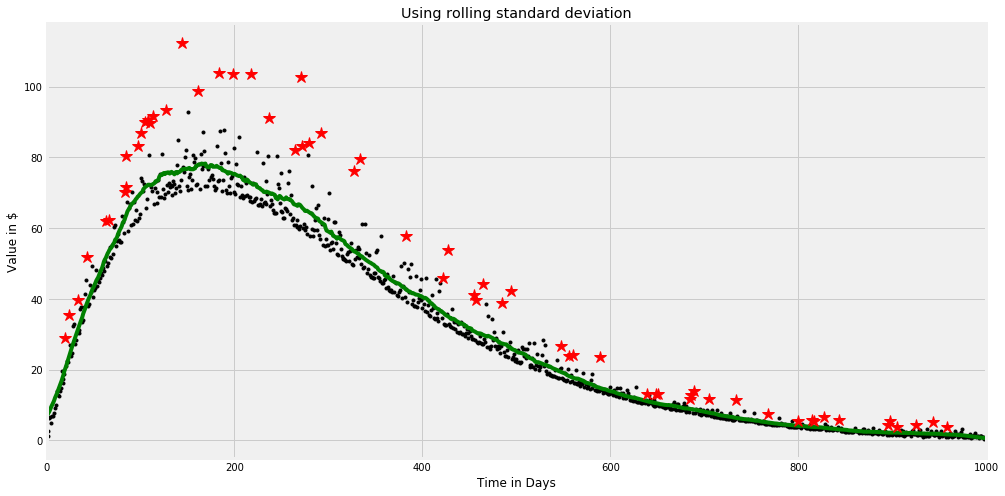

In [55]:
# Lets play
x1, y1 = generate_random_dataset()
# Using stationary standard deviation over a continuous sample replicating
plot_results(x1, y1, window_size=12, title_for_plot="Statinoary Standard Deviation",
                    sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $")

# using rolling standard deviation for
x1, y1 = generate_random_dataset()
plot_results(x1, y1, window_size=50, title_for_plot="Using rolling standard deviation",
             sigma_value=2, text_xlabel="Time in Days", text_ylabel="Value in $", applying_rolling_std=True)